## Flow Matching for Trajectories
* Adapted from https://github.com/dome272/Flow-Matching/blob/main/flow-matching.ipynb


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from torch import nn
import torch

## Frame and Trajectory generation

In [2]:
# Frame dimensions
x_min, x_max = 0, 100
y_min, y_max = 0, 100

# Define pillar dimensions
pillar_width = 0.6 * (x_max - x_min)
pillar_height = 0.25 * (y_max - y_min)

# Calculate pillar bounds
pillar_x_min = x_min
pillar_x_max = x_min + int(pillar_width)
pillar_y_min = y_min + (y_max - y_min) // 2 - int(pillar_height / 2)
pillar_y_max = pillar_y_min + int(pillar_height)

# Function to check if a point is inside the blocked area
def is_inside_pillar(x, y):
    return (pillar_x_min <= x < pillar_x_max) and (pillar_y_min <= y < pillar_y_max)

def generate_trajectories(num_trajectories, num_steps):
    trajectories = []
    while len(trajectories) != num_trajectories:
        # Random starting point within the frame
        x_start = np.random.uniform(x_min, x_max)
        y_start = np.random.uniform(y_min, y_max)
        
        # Generate trajectory points
        trajectory = [(x_start, y_start)]
        for _ in range(num_steps - 1):
            # Generate random movement (e.g., random walk)
            x_new = trajectory[-1][0] + np.random.uniform(-1, 1)
            y_new = trajectory[-1][1] + np.random.uniform(-1, 1)
            trajectory.append((x_new, y_new))
        trajectories.append(trajectory)
        # # Check if any point of the trajectory is inside the pillar
        # if not any(is_inside_pillar(x, y) for x, y in trajectory):
        #     trajectories.append(trajectory)
    trajectories = np.array(trajectories)
    return trajectories

In [3]:
# Parameters
num_trajectories = 10
num_steps = 500

# Generate valid trajectories
valid_trajectories = generate_trajectories(num_trajectories, num_steps)

def show_trajectories(valid_trajectories):
    plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max])

    plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='red', alpha=0.5) # "Pillar"

    # Plot valid trajectories
    for count, trajectory in enumerate(valid_trajectories):
        plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label=f"Trajectory {count}")

    plt.title("Valid Trajectories with 'Blocked Area'")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    # plt.legend()
    plt.show()

## Show Trajectories

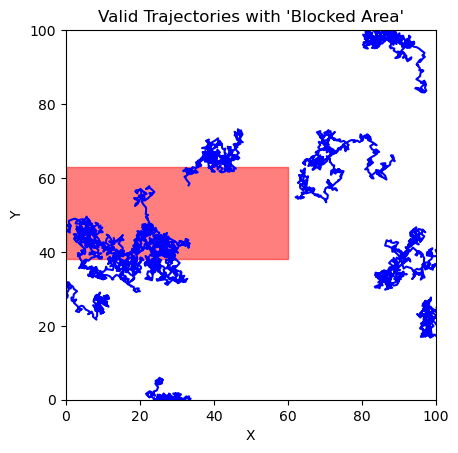

In [4]:
show_trajectories(valid_trajectories)

## Model Architecture

In [5]:

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb_scale = math.log(max_positions) / (half_dim - 1)
        frequencies = torch.arange(half_dim, device=t.device).float().mul(-emb_scale).exp()
        emb = t[..., None] * frequencies
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)

        if self.channels_t % 2 == 1:
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x_extended = x.unsqueeze(2).expand(-1, -1, t.size(2), -1)
        x = x_extended + t 
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [6]:
model = MLP(layers=5, channels=512)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
model_path = "Saved_model/"

## Load pretrained model

In [7]:
# model = MLP(*args, **kwargs)
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.eval()

## Training

In [8]:
import tqdm
data = torch.tensor(valid_trajectories, dtype=torch.float32)
num_steps = data.shape[1]
num_trajectories = data.shape[0] 
training_steps = 1000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    batch_indices = torch.randint(data.size(0), (batch_size,))
    x1 = data[batch_indices]
    x0 = torch.randn_like(x1)
    target = x1 - x0
    target = target.unsqueeze(2).expand(-1, num_steps, -1, -1)
    t = torch.rand(x1.size(0))
    t = t[:, None, None] 
    t = t.expand(t.size(0), num_steps, 2)
    xt = (1 - t) * x0 + t * x1
    pred = model(xt, t)
    loss = ((target - pred) ** 2).mean() # L2 loss
    loss.backward()
    optim.step()
    optim.zero_grad()   
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

torch.save(model.state_dict(), model_path)


 54%|█████▍    | 539/1000 [25:36<22:03,  2.87s/it, loss=89.3]   

## Loss plotting

In [ ]:
plt.plot(losses)

## Sampling

In [ ]:
import os
batch_size = 64
torch.manual_seed(42)
model.eval().requires_grad_(False)
xt = torch.randn(batch_size, num_steps, 2)
steps = 1000
plot_every = 100
savepath = "FM_Progression"
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    t = t.view(1, 1, 1).expand(xt.size(0), xt.size(1), xt.size(2))
    pred = model(xt, t)
    pred = pred[:, :, 0, :]
    xt = xt + (1/steps) * pred
    if i % plot_every == 0:
        plt.imshow(np.zeros((y_max - y_min + 1, x_max - x_min + 1)), origin="lower", cmap="Greys", extent=[x_min, x_max, y_min, y_max])
        plt.fill_betweenx([pillar_y_min, pillar_y_max], pillar_x_min, pillar_x_max, color='red', alpha=0.5)
        for count, trajectory in enumerate(valid_trajectories):
            trajectory = np.array(trajectory)
            plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label=f"Trajectory {count}", alpha=0.5)
        plt.scatter(xt[:, :, 0].detach().numpy(), xt[:, :, 1].detach().numpy(), color='green', alpha=0.8)
        plt.title("Valid Trajectories Outside Blocked Area")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        # plt.legend()
        plt.show()
        # Create directory if it doesn't exist
        if not os.path.exists(savepath):
            os.makedirs(savepath)

        # Save the plot
        fig_path = join(savepath, f"FM_Progression{i}.png")
        plt.savefig()
        plt.close()
        
model.train().requires_grad_(True)
print("Done sampling")